# Settings

In [1]:
# Load Reticulate function
Sys.setenv(RETICULATE_PYTHON="/home/luca/anaconda3/envs/reticulate/bin/python")
library(reticulate)
reticulate::use_python("/home/luca/anaconda3/envs/reticulate/bin/python")
reticulate::use_condaenv("/home/luca/anaconda3/envs/reticulate")
reticulate::py_module_available(module='anndata') #needs to be TRUE
reticulate::import('anndata') #good to make sure this doesn't error
reticulate::py_module_available(module='leidenalg') #needs to be TRUE
reticulate::import('leidenalg') #good to make sure this doesn't error

[1] TRUE

Module(anndata)

[1] TRUE

Module(leidenalg)

In [3]:
# Load packages
pacman::p_load(dplyr, stringr, data.table, tidyr, data.table, Matrix,
               hdf5r, Seurat, Signac,harmony, knitr, SoupX,
               logr, parallel, 
               ggplot2, ggpubr, ggrepel, ggbreak, gridExtra,grid, ggh4x)

In [5]:
# Set options
options(stringsAsFactors = FALSE)
warnLevel <- getOption('warn')
options(warn = -1)
opts_chunk$set(tidy=TRUE)

In [6]:
# Set directories
fastq.dir = "/nfs/lab/projects/COVID_mouse/raw_data/230616_A01535_0344_BH7LF2DSX7_2/"
base.dir = "/nfs/lab/projects/COVID_mouse/"
assets.dir = "/nfs/lab/projects/COVID_mouse/assets/"
cell.ranger.dir = paste(base.dir, "cell.ranger/", sep = "")
seurat.dir = paste(base.dir, "seurat/", sep = "")
step1.dir = paste(seurat.dir, "1_pre.processing/", sep = "")
step2.dir = paste(seurat.dir, "2_SoupX/", sep = "")

In [7]:
# start log
options("logr.on" = TRUE, "logr.notes" = TRUE)
options("logr.autolog" = TRUE)
options("logr.compact" = TRUE)
options("logr.traceback" = TRUE)
log.file = paste(base.dir, Sys.Date(),".2_SoupX.log", sep="")

In [8]:
log_open(log.file)

[1] "/nfs/lab/projects/COVID_mouse/log/2023-08-16.2_SoupX.log"

# Load sample list

In [9]:
setwd(cell.ranger.dir)
sample.ls = dir()
sample.ID.ls = gsub(x = sample.ls, pattern = "_1_2", replacement = "")
sample.ID.ls = gsub(x = sample.ID.ls, pattern = "_JB_", replacement = "_")
sample.ID.ls = gsub(x = sample.ID.ls, pattern = "_MM_", replacement = "_")
sample.ID.ls = gsub(x = sample.ID.ls, pattern = "_QY_", replacement = "_")
sample.ls
sample.ID.ls

[1] "1_GFP1"  "10_G1C1" "11_G1C2" "12_G1C3" "2_GFP2"  "3_GFP3"  "4_RBD1" 
 [8] "5_RBD2"  "6_RBD3"  "7_G1B1"  "8_G1B2"  "9_G1B3"

[1] "1_GFP1"  "10_G1C1" "11_G1C2" "12_G1C3" "2_GFP2"  "3_GFP3"  "4_RBD1" 
 [8] "5_RBD2"  "6_RBD3"  "7_G1B1"  "8_G1B2"  "9_G1B3"

In [ ]:
## Make some marker plots here

In [45]:
# Set list of genes we want to check
marker.genes.short = c("Nrgn", "Vpreb1", "Csf1r", "Cebpe",
                       "Cd3d")

# Run SoupX 

In [46]:
snRNAseq_SoupX <- function(i) {
    gc(reset = TRUE)
    # Set sample variable
    sample = sample.ls[i]
    sample.ID = sample.ls[i]
    log_print(paste("Starting the analysis of:", sample.ID))
    sample.dir <- paste(cell.ranger.dir, sprintf('%s/outs/', sample), sep = "")
    # Load sample
    adata = readRDS(paste(step1.dir, sample.ID, "_pre.filt.rds", sep = ""))
    #Read in RNA assay counts from filtered seurat object
    DefaultAssay(adata) <- 'RNA'
    toc = GetAssayData(object = adata, slot = "counts") #filtered cells
    #Read in raw RNA counts from CellRanger outputs
    tod = Seurat::Read10X_h5(file.path(sample.dir, 'raw_feature_bc_matrix.h5'))
    #Compile necessary metadata (pull out the required metadata from the clustered filtered 
    #adata object; we need the UMAP coordinates (RD1 and RD2) and the cluster assignments at minimum)
    metadata <- (cbind(as.data.frame(adata[["umap"]]@cell.embeddings),
                   as.data.frame(Idents(adata)),
                   as.data.frame(Idents(adata))))
    colnames(metadata) <- c("RD1","RD2","Cluster","Annotation")
    log_print(paste("Check that TOC and TOD barcodes match:", sample.ID))
    #Make sure the metadata BCs match the toc matrix barcodes
    log_print("Checking all necssary barcode and gene indices match")
    if (FALSE %in% (row.names(metadata) %in% colnames(toc)) == TRUE) {
      stop('Not all metadata barcodes found in toc')}
    if (FALSE %in% (colnames(toc) %in% row.names(metadata)) == TRUE) {
      stop('Not all toc barcodes found in metadata')}

    #Make sure the toc and tod indices match
    if (FALSE %in% (row.names(tod) %in% row.names(toc)) == TRUE) {
      stop("Not all tod genes found in toc")}
    if (FALSE %in% (row.names(toc) %in% row.names(tod)) == TRUE) {
      stop("Not all toc genes found in tod")}
    if (FALSE %in% (row.names(toc) == row.names(tod)) == TRUE) {
      stop("toc and tod gene indices don't match")
    }
    log_print("Looks good!")
    
    # Create a Soup Channel object and add in the metadata
    sc <- SoupChannel(tod,toc)
    sc <- setDR(sc,metadata[colnames(sc$toc),c("RD1","RD2")])
    sc <- setClusters(sc,setNames(metadata$Cluster,rownames(metadata)))
    # Autodetect noise
    sc <- autoEstCont(sc)
        #Output the estimated percentage of background as a separate file
        background <- sc$soupProfile[order(sc$soupProfile$est,decreasing=TRUE),] 
        write.table(background, paste(step2.dir, sample.ID,".SoupX_est_background.csv", sep=""), 
                    sep='\t', col.names = TRUE, row.names = TRUE, quote = FALSE) 
        # Grab Contamination Fraction
        contamination_fraction <- mean(sc$metaData$rho*100)
    # round soupX count for downstream
    out <- adjustCounts(sc, roundToInt=TRUE)
        # Visualize changes to expression profile post SoupX
        gene_names <- row.names(out)
        marker.genes.short <- marker.genes.short[marker.genes.short %in% gene_names]
        # Plot
        # Output change maps for select marker genes (add titles and use ggarrange)
        plot.ls = list()
        for(plot.i in seq_along(marker.genes.short)){
            theme_set(theme_bw() + 
            theme(panel.border = element_blank(), panel.grid.major = element_blank(),
                  panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                  plot.title = element_text(size = 20, hjust = 0.5),
                  legend.key.size = unit(1, 'cm'), legend.title = element_text(size=15),
                  legend.text = element_text(size=15),
                  axis.title = element_blank(), axis.text = element_text(size=15)))
            plot.ls[[plot.i]] = plotChangeMap(sc, out, marker.genes.short[[plot.i]])+ 
            ggtitle(marker.genes.short[[plot.i]])+ 
            theme(axis.title.y = element_text(size=15)) 
        }
        file <- paste(step2.dir, sample.ID,'SoupX_ChangeMaps.png', sep="")
        png(file, width = 700, height = 700)
        figure <- ggarrange(plotlist = plot.ls, common.legend = TRUE,legend="bottom")
        print(figure)
        garbage <- dev.off()
    
    ### Load Post SoupX RNA into Seurat Object
    log_print('Creating new Seurat Object with SoupX Counts')
    adata2 = CreateSeuratObject(out)
    adata2[['percent.mt']] <- PercentageFeatureSet(adata2, pattern = '^MT-')

    #add in previous raw RNA data as another assay (RNA_raw)
    DefaultAssay(adata) <- 'RNA'
    raw_rna <-  GetAssayData(object = adata, slot = "counts")
    raw_rna_assay <- CreateAssayObject(counts = raw_rna)
    adata2[['RNA_raw']] <- raw_rna_assay

    ### Analyze and cluster the post-SoupX object
    # RNA analysis
    DefaultAssay(adata2) <- 'RNA'
    adata2 <- SCTransform(adata2, verbose = FALSE) 
    DefaultAssay(adata2) <- "SCT"
    adata2 = RunPCA(adata2, verbose = FALSE)
    adata2 = RunUMAP(adata2, dims = 1:30, verbose = FALSE)
    adata2 = FindNeighbors(adata2, dims = 1:30, verbose = FALSE)
    adata2 = FindClusters(adata2, algorithm = 4, resolution = 0.5, verbose = FALSE)
    
    # Add log counts and features
    adata2$log_nCount_SCT = log(adata2$nCount_SCT)
    adata2$log_nFeature_SCT = log(adata2$nFeature_SCT)

    ### Save final Seurat object to an .rds file 
    log_print("Saving final RDS")
    ### Save intermediate RDS
    file = paste(step2.dir, sample.ID, "_SoupX_filt.rds", sep = "")
    saveRDS(adata2, file = file)

    ## Save barcodes
    file = paste(step2.dir, sample.ID, "_SoupX_filt.barcodes.txt", sep = "")
    filtered_bcs <- colnames(adata2[["RNA"]])
    write(filtered_bcs, file=file) 
    log_print("all done!!")
    
    # print contamination fraction
    qc.data = cbind(sample.ID, contamination_fraction)
    return(qc.data)
}

In [47]:
cores <- 12
cl <- makeCluster(cores)
setDefaultCluster(cl)

log_print(paste("Starting SoupX correction"))
qc.data.ls = NULL
# Process samples
qc.data.ls = mclapply(1:length(sample.ls), function(i) snRNAseq_SoupX(i), mc.cores = cores)

[1] "Starting SoupX correction"


In [48]:
# Clean up the parallel backend
setDefaultCluster(NULL)
stopCluster(cl)

In [49]:
# Combine results into single dataframe
qc.data <- as.data.frame(do.call(rbind, qc.data.ls))
file = paste(step2.dir, "Cell.res.qc", sep = "")
fwrite(qc.data, file, sep='\t', row.names=FALSE, col.names=TRUE, quote=FALSE)

In [50]:
qc.data

sample.ID,contamination_fraction
<chr>,<chr>
1_GFP1,1.3
10_G1C1,3.7
11_G1C2,2.3
12_G1C3,2.4
2_GFP2,1.6
3_GFP3,3
4_RBD1,2.1
5_RBD2,2
6_RBD3,1.2


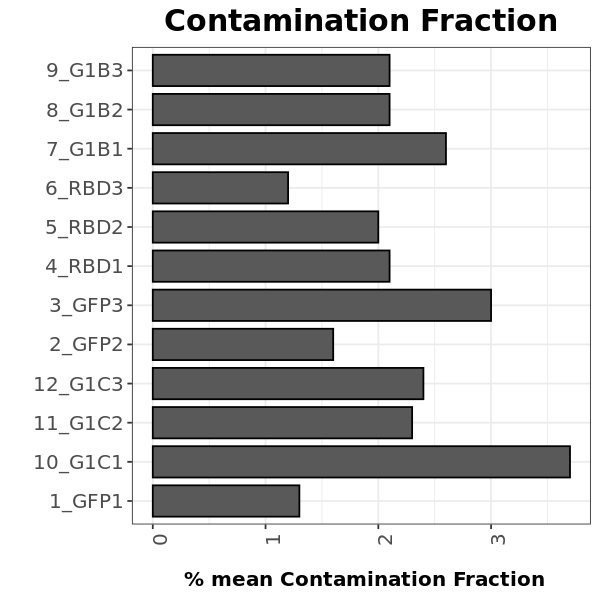

In [51]:
options(repr.plot.width=5, repr.plot.height=5)
qc.data$contamination_fraction = as.numeric(qc.data$contamination_fraction)
width = 0.8
position = position_dodge(width = width)
gg1 = ggplot(qc.data, aes(x= sample.ID, y = contamination_fraction)) + 
            theme_bw () +
            labs(y= "\n % mean Contamination Fraction", x = "", title = "Contamination Fraction") +
            geom_bar(stat="identity", 
                     position = position, width = width,
                     colour="black") +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            coord_flip()
gg1

In [52]:
## Make a consensus of contaminant gene
Contamination.data <- data.frame(
                  est = numeric(),
                  counts = numeric(),
                  sample = character(),
                  gene = character(),
                  stringsAsFactors = FALSE)

for (i in seq_along(sample.ls)){
    
    gc(reset = TRUE)
    # Set sample variable
    sample = sample.ls[i]
    sample.ID = sample.ID.ls[i]
    log_print(paste("Reading BG genes of: ", sample.ID))
    Contamination.data.use = read.table(paste(step2.dir, sample.ID, ".SoupX_est_background.csv", sep = ""), 
                                sep = "\t", header = TRUE)
    Contamination.data.use$sample = sample.ID
    Contamination.data.use$gene = rownames(Contamination.data.use)
    Contamination.data = merge(Contamination.data, Contamination.data.use, all = TRUE)
}

[1] "Reading BG genes of:  1_GFP1"
[1] "Reading BG genes of:  10_G1C1"
[1] "Reading BG genes of:  11_G1C2"
[1] "Reading BG genes of:  12_G1C3"
[1] "Reading BG genes of:  2_GFP2"
[1] "Reading BG genes of:  3_GFP3"
[1] "Reading BG genes of:  4_RBD1"
[1] "Reading BG genes of:  5_RBD2"
[1] "Reading BG genes of:  6_RBD3"
[1] "Reading BG genes of:  7_G1B1"
[1] "Reading BG genes of:  8_G1B2"
[1] "Reading BG genes of:  9_G1B3"


group_by: one grouping variable (sample)
slice_max (grouped): removed 387,120 rows (>99%), 300 rows remaining
group_by: one grouping variable (gene)
summarize: now 45 rows and 2 columns, ungrouped
mutate (grouped): new variable 'gene_reordered' (factor) with 45 unique values and 0% NA


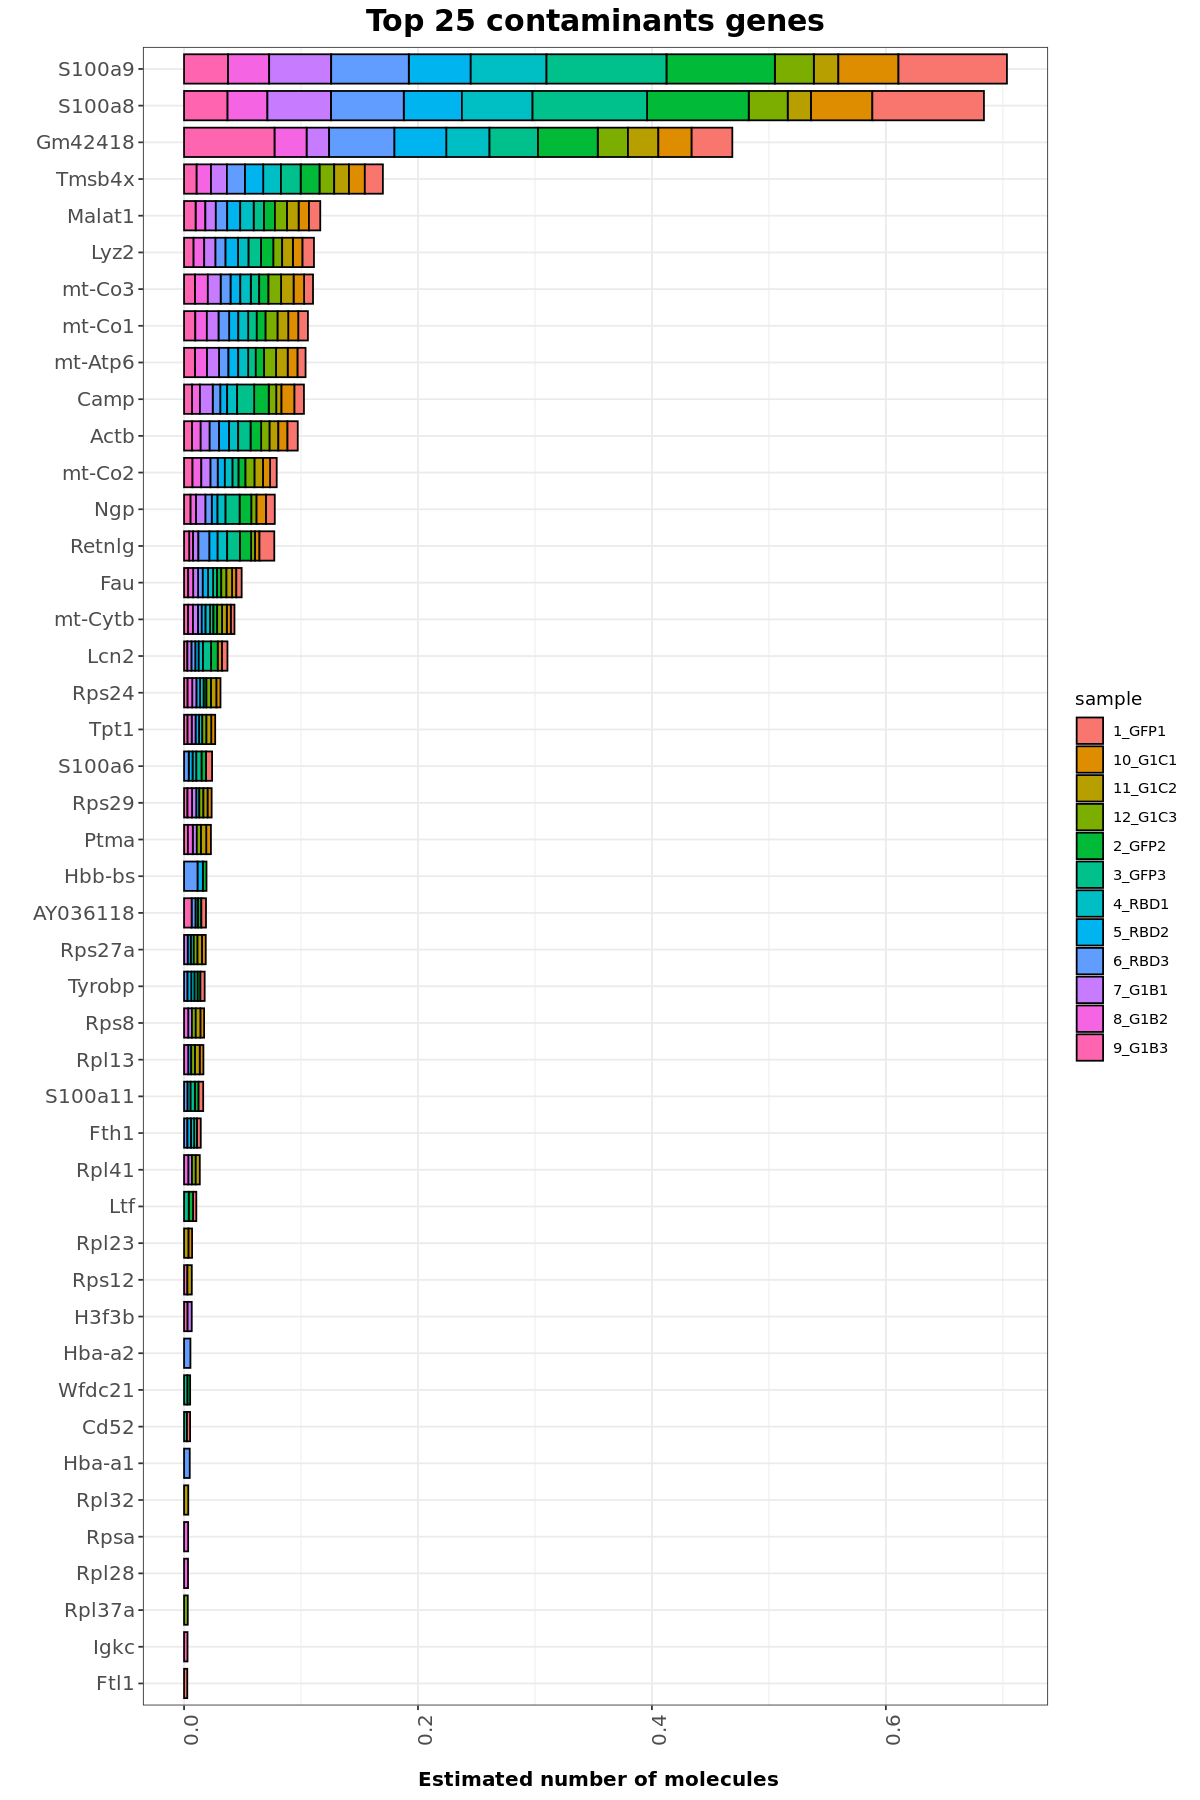

In [53]:
# Select the top x genes based on the counts column for each sample
top_genes <- Contamination.data %>%
  group_by(sample) %>%
  slice_max(est, n = 25) %>%
  arrange(est)

# Calculate sum of est by gene
gene_sum_est <- top_genes %>% 
  group_by(gene) %>% 
  summarize(sum_est = sum(est)) %>% 
  arrange(sum_est) # arrange in descending order of sum of est

# Create new factor variable for reordered genes
top_genes <- top_genes %>% 
  mutate(gene_reordered = factor(gene, levels = gene_sum_est$gene))

# Plot with reordered genes
options(repr.plot.width=10, repr.plot.height=15)
width <- 0.8
gg1 = ggplot(top_genes, aes(x = gene_reordered, y = est, fill = sample)) +   
  theme_bw() +
  labs(y = "\n Estimated number of molecules", x = "", title = "Top 25 contaminants genes") +
  geom_bar(stat = "identity", width = width, colour = "black") +
  theme(axis.text = element_text(size = 12), 
        axis.title = element_text(size = 12, face = "bold"),
        axis.text.x = element_text(angle = 90),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5)) +
  coord_flip()

gg1

In [ ]:
for (i in seq_along(sample.ls)){
    gc(reset = TRUE)
    # Set sample variable
    sample = sample.ls[i]
    sample.ID = sample.ls[i]
    log_print(paste("Generating plots for sample: ", sample))
    # Load sample
    adata = readRDS(paste(step2.dir, sample.ID, "_SoupX_filt.rds", sep = ""))
    
    # Generate UMAPS
    file = paste(step2.dir, sample.ID,"_UMAPs.png", sep = "")
    png(file, width = 576, height = 576)
    p1 <- DimPlot(adata, group.by='seurat_clusters', label=TRUE, label.size=8, repel=TRUE)
    p1 <- p1 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle(sample.ID) + theme(legend.position = "none")
    print(p1)
    garbage <- dev.off()
    
}

[1] "Generating plots for sample:  1_GFP1"
[1] "Generating plots for sample:  10_G1C1"
[1] "Generating plots for sample:  11_G1C2"
[1] "Generating plots for sample:  12_G1C3"
[1] "Generating plots for sample:  2_GFP2"
[1] "Generating plots for sample:  3_GFP3"
[1] "Generating plots for sample:  4_RBD1"
[1] "Generating plots for sample:  5_RBD2"
[1] "Generating plots for sample:  6_RBD3"
[1] "Generating plots for sample:  7_G1B1"
[1] "Generating plots for sample:  8_G1B2"
[1] "Generating plots for sample:  9_G1B3"
